In [16]:
# Import necessary libraries
import os
import re
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from wordcloud import WordCloud

# Preprocessing

In [3]:
# Function to load data from folder path
def load_data(folder_path):
    articles = []
    
	# Iterate through all files in the folder path
    for file in os.listdir(folder_path):
        with open(os.path.join(folder_path, file), "r", encoding="latin") as f:
            content = f.read()
            articles.append(content)
    return articles

In [4]:
# Function to preprocess the loaded data
def preprocess_data(article_files):
    cleaned_articles = []

    # Iterate through each file in the article file list
    for article_file in article_files:
        # Split individual articles using unicode character U+000c which is at the end of each article
        articles = article_file.split('')

        # Iterate through each article in the current file
        for article in articles:
            # Remove article metadata
                # removes everything between By and Reserved
            text = re.sub(r"(?s)(?<=By).*?(?=Reserved)", "", article)
                # remove By and remove Reserved
            text = re.sub(r"By", "", text, count=1)
            text = re.sub(r"Reserved", "", text, count=1)
            # Remove related articles section
            text = re.sub(r"(?s)(?<=\*).*?(?=Document)", "", text)
            # Remove Document from metadata at end of each article
            text = re.sub(r"Document", "", text, count=1)
	        # Remove new line characters
            text = re.sub(r"\s+", " ", text)
            # Remove numbers and punctuation
            text = re.sub(r"[^a-zA-Z\s]", "", text)
            # Make all characters lowercase
            text = text.lower()

            # Tokenize text into words
            tokens = word_tokenize(text)
	        # Remove stop words (common words with little meaning such as "the" or "a")
            stop_words = set(stopwords.words("english"))
            custom_stopwords = {"mr", "said", "u"}  # Add any additional stopwords here
            stop_words = stop_words.union(custom_stopwords)
	        # Remove any remaining short words and lemmatize 
            tokens = [token for token in tokens if token not in stop_words]
            tokens = [token for token in tokens if len(token) > 1 or token in {"i", "a"}]
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            tokens = [token for token in tokens if token != "u"]
            cleaned_articles.append(tokens)
    return cleaned_articles

In [5]:
# Function to create a corpus and dictionary from the preprocessed data
def create_corpus_dictionary(cleaned_articles):
    dictionary = corpora.Dictionary(cleaned_articles)
    corpus = [dictionary.doc2bow(article) for article in cleaned_articles]
    return corpus, dictionary

In [6]:
# Run preprocessing functions
folder_path = "Articles/"
article_files = load_data(folder_path)
cleaned_articles = preprocess_data(article_files)
corpus, dictionary = create_corpus_dictionary(cleaned_articles)

# EDA

In [14]:
# Print total number of articles using length of cleaned_articles list
print("Article Count: ", len(cleaned_articles))

Article Count:  1622


c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 

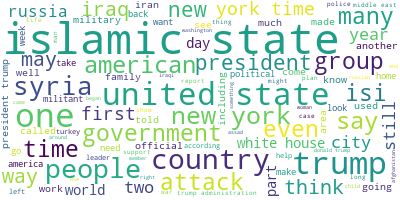

In [19]:
# Generate a word cloud to see most frequent words in the whole corpus

temp_list = [' '.join(x) for x in cleaned_articles]
word_string = ' '.join(temp_list)
wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate(word_string)
wordcloud.to_image()

# Topic Models

In [151]:
# Function to train an LDA model
def train_lda(corpus, dictionary, num_topics, passes):
    lda_model = models.LdaModel(corpus=corpus,
                                num_topics=num_topics,
                                id2word=dictionary,
                                passes=passes,
                                random_state=13)
    return lda_model

In [152]:
# Function to print and plot the topics from an LDA model
def plot_topics(lda_model):
    num_topics = lda_model.num_topics
    topic_words = lda_model.print_topics(num_words=10)
    
    for topic in range(num_topics):
        print(f"Topic {topic}:")
        print(topic_words[topic])

In [153]:
# Function to run the LDA training and save the results to a file
def run_and_save_lda(corpus, dictionary, num_topics, passes, model_number, output_file):
    lda_model = train_lda(corpus, dictionary, num_topics, passes)

    # save the 4 models to Models/ folder
    temp_file = 'Models/lda_model_' + str(model_number+1)
    lda_model.save(temp_file)

    # Save the topic words to output files
    topic_words = lda_model.print_topics(num_words=10)
    with open(output_file, "w") as f:
        for topic in range(num_topics):
            f.write(f"Topic {topic}:\n")
            f.write(str(topic_words[topic]) + "\n\n")

In [154]:
# Define different parameters to build the LDA model
# use different topic and pass count and discuss differences in report
params = [{"num_topics": 5, "passes": 10},{"num_topics": 10, "passes": 10},{"num_topics": 5, "passes": 20},{"num_topics": 10, "passes": 20}]


# Iterating through the parameters and building different LDA models
for i, p in enumerate(params):
    output_file = f"output_{i + 1}.txt"
    run_and_save_lda(corpus, dictionary,  p["num_topics"], p["passes"], i, output_file)

# Evaluation

In [155]:
# Load models from Models folder
model_1 = models.ldamodel.LdaModel.load("Models/lda_model_1")
model_2 = models.ldamodel.LdaModel.load("Models/lda_model_2")
model_3 = models.ldamodel.LdaModel.load("Models/lda_model_3")
model_4 = models.ldamodel.LdaModel.load("Models/lda_model_4")
models_list = [model_1, model_2, model_3, model_4]

In [156]:
# Function to print Coherence Score of model
def compute_coherence(lda_model):
    coherence_lda_model = CoherenceModel(model=lda_model, texts=cleaned_articles, dictionary=dictionary, coherence='c_v')
    coherence_number = coherence_lda_model.get_coherence()
    print('Coherence:  ', coherence_number)

In [157]:
#variable to print which model the following score is for; iterated on in loop
model_number = 0

# Compute Perplexity and Coherence of all 4 models
for m in models_list:
    model_number+=1
    print('Model ', model_number)
    print('Perplexity: ', m.log_perplexity(corpus))
    compute_coherence(m)
    print('\n')

Model  1
Perplexity:  -8.41601490634937
Coherence:   0.45211070162587796


Model  2
Perplexity:  -8.401235125856905
Coherence:   0.3925426368927533


Model  3
Perplexity:  -8.400911385959953
Coherence:   0.4698770255792971


Model  4
Perplexity:  -8.379358880386505
Coherence:   0.3980192204523535




# Visualization

In [158]:
# Enable Python Notebook display of pyLDAvis
pyLDAvis.enable_notebook()


In [159]:

# Model 1 visualization
vis = pyLDAvis.gensim_models.prepare(model_1, corpus, dictionary)
vis

c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.113947 -0.048304       1        1  34.115404
3     -0.086390 -0.074284       2        1  20.692108
4     -0.054410  0.038718       3        1  20.262946
2      0.016701  0.052187       4        1  13.869998
1      0.010153  0.031683       5        1  11.059544, topic_info=         Term         Freq        Total Category  logprob  loglift
407     state  9753.000000  9753.000000  Default  30.0000  30.0000
215   islamic  5891.000000  5891.000000  Default  29.0000  29.0000
451     trump  7013.000000  7013.000000  Default  28.0000  28.0000
774      iraq  2905.000000  2905.000000  Default  27.0000  27.0000
430     syria  3671.000000  3671.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
445      time   367.524596  3706.653734   Topic5  -5.7111  -0.1092
289       one   372.873227  4058.859514   Topic5  -5.6966  -0.1855
619  national   254.436119  1299.403304   Topic5  -6.0788   0.5713
430     syria   338.071288  3671.060616   Topic5  -5.7946  -0.1831
763     group   256.311752  3171.561981   Topic5  -6.0715  -0.3137

[461 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
849        1  0.005575       abadi
849        2  0.005575       abadi
849        3  0.986700       abadi
849        4  0.005575       abadi
849        5  0.005575       abadi
...      ...       ...         ...
32519      3  0.022540      zarrab
32519      4  0.969223      zarrab
35827      4  0.927598      ziadeh
4544       1  0.980922  zuckerberg
4544       4  0.007663  zuckerberg

[1220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])

In [160]:
# Model 2 visualization
vis = pyLDAvis.gensim_models.prepare(model_2, corpus, dictionary)
vis

c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.053562  0.089373       1        1  28.248854
0      0.079389 -0.036131       2        1  18.443826
6      0.149795  0.053001       3        1  14.308938
3     -0.113271 -0.022968       4        1  12.756031
4     -0.035504  0.065888       5        1  11.239812
2      0.026138  0.028049       6        1   4.737324
5     -0.023888 -0.055295       7        1   2.990498
1      0.028687 -0.031499       8        1   2.781837
7     -0.006365 -0.140849       9        1   2.735124
9     -0.051419  0.050430      10        1   1.757757, topic_info=            Term         Freq        Total Category  logprob  loglift
407        state  9930.000000  9930.000000  Default  30.0000  30.0000
215      islamic  6004.000000  6004.000000  Default  29.0000  29.0000
774         iraq  2929.000000  2929.000000  Default  28.0000  28.0000
451        trump  7149.000000  7149.000000  Default  27.0000  27.0000
275          new  3871.000000  3871.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
775          isi    46.813378  2690.882203  Topic10  -5.9324  -0.0103
921        iraqi    43.950824  2092.888421  Topic10  -5.9955   0.1779
186   government    41.948634  2624.979720  Topic10  -6.0422  -0.0953
1066       could    39.832812  2132.025250  Topic10  -6.0939   0.0610
100      country    38.969650  3085.829712  Topic10  -6.1158  -0.3307

[870 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
849        1  0.038799       abadi
849        5  0.936715       abadi
849        8  0.016628       abadi
13808      5  0.953613      abadis
13808     10  0.026489      abadis
...      ...       ...         ...
32520     10  0.878306     zarrabs
35827      6  0.954703      ziadeh
4544       2  0.940756  zuckerberg
4544       3  0.007775  zuckerberg
4544       6  0.038874  zuckerberg

[3062 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 7, 4, 5, 3, 6, 2, 8, 10])

In [161]:
# Model 3 visualization
vis = pyLDAvis.gensim_models.prepare(model_3, corpus, dictionary)
vis

c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.123960 -0.061598       1        1  34.247908
3      0.100634 -0.092850       2        1  20.672826
4      0.070076  0.056688       3        1  20.311818
2     -0.022903  0.070784       4        1  13.699521
1     -0.023847  0.026975       5        1  11.067927, topic_info=         Term         Freq        Total Category  logprob  loglift
407     state  9814.000000  9814.000000  Default  30.0000  30.0000
451     trump  6996.000000  6996.000000  Default  29.0000  29.0000
215   islamic  5926.000000  5926.000000  Default  28.0000  28.0000
774      iraq  2946.000000  2946.000000  Default  27.0000  27.0000
430     syria  3681.000000  3681.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
22       also   398.454855  2993.484027   Topic5  -5.6310   0.1845
215   islamic   453.498839  5926.955349   Topic5  -5.5016  -0.3692
1896   russia   301.381589  1624.824909   Topic5  -5.9102   0.5163
445      time   363.690792  3696.111653   Topic5  -5.7223  -0.1176
289       one   343.704283  4050.625447   Topic5  -5.7788  -0.2657

[452 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
849        3  0.996466       abadi
13808      3  0.988945      abadis
19311      1  0.011440       abedi
19311      2  0.972439       abedi
19311      3  0.011440       abedi
...      ...       ...         ...
4921       5  0.020781         ypg
29247      5  0.896753   zakharova
32519      4  0.977109      zarrab
35827      4  0.934988      ziadeh
4544       1  0.990551  zuckerberg

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])

In [162]:
# Model 4 visualization
vis = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
vis

c:\Users\Dustin\anaconda3\envs\textminingclass\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.004717 -0.126187       1        1  28.122041
0      0.067703  0.066225       2        1  18.474146
6      0.170047  0.006014       3        1  15.145811
3     -0.128141 -0.044133       4        1  13.414220
4     -0.005804 -0.094424       5        1  11.142976
2      0.035871 -0.007675       6        1   4.233985
7     -0.071674  0.134718       7        1   2.939385
5     -0.072271  0.058915       8        1   2.624705
1      0.018487  0.069547       9        1   2.408883
9     -0.009501 -0.063002      10        1   1.493847, topic_info=        Term         Freq        Total Category  logprob  loglift
407    state  9947.000000  9947.000000  Default  30.0000  30.0000
215  islamic  6010.000000  6010.000000  Default  29.0000  29.0000
451    trump  7148.000000  7148.000000  Default  28.0000  28.0000
774     iraq  2954.000000  2954.000000  Default  27.0000  27.0000
275      new  3880.000000  3880.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
289      one    38.267154  4047.295572  Topic10  -5.9713  -0.4574
445     time    37.681240  3675.816530  Topic10  -5.9868  -0.3766
775      isi    35.835019  2696.489618  Topic10  -6.0370  -0.1170
100  country    34.729868  3084.593048  Topic10  -6.0683  -0.2828
900    force    34.558578  3456.522341  Topic10  -6.0733  -0.4015

[861 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
849        1  0.010986       abadi
849        5  0.972261       abadi
849        9  0.016479       abadi
13808      5  0.970598      abadis
13808     10  0.026232      abadis
...      ...       ...         ...
32520     10  0.871434     zarrabs
35827      6  0.929460      ziadeh
4544       2  0.967983  zuckerberg
4544       3  0.007744  zuckerberg
4544       6  0.023232  zuckerberg

[2884 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 7, 4, 5, 3, 8, 6, 2, 10])